In [1]:
# Copyright 2020 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Overview

In this notebook, you will learn how to load, explore, visualize, and pre-process a time-series dataset. The output of this notebook is a processed dataset that will be used in following notebooks to build a machine learning model.

### Dataset

City of New York 311 Service Requests dataset.

### Objective

The goal is to predict 311 service requests from the City of New York. These non-emergency requests include noise complaints, street light issues, etc.

## Install packages and dependencies

Restarting the kernel may be required to use new packages.

In [2]:
%pip install -U statsmodels scikit-learn --user

Note: you may need to restart the kernel to use updated packages.


**Note:** To restart the Kernel, navigate to Kernel > Restart Kernel... on the Jupyter menu.

### Import libraries and define constants

In [3]:
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import grangercausalitytests

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [4]:
# Enter your project and region. Then run the  cell to make sure the
# Cloud SDK uses the right project for all the commands in this notebook.

PROJECT = 'Deep Learning - Assignment 2' # REPLACE WITH YOUR PROJECT NAME 
REGION = 'us-central-1' # REPLACE WITH YOUR REGION e.g. us-central1

#Don't change the following command - this is to check if you have changed the project name above.
assert PROJECT != 'your-project-name', 'Don''t forget to change the project variables!'

### Explore Data

In [8]:
from google.cloud import bigquery as bq

sql = """
SELECT * FROM `bigquery-public-data.new_york_311.311_service_requests` LIMIT 5
"""

client = bq.Client(project="direct-hope-306504")
limit_df = client.query(sql).to_dataframe()

limit_df.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,...,vehicle_type,taxi_company_borough,taxi_pickup_location,bridge_highway_name,bridge_highway_direction,road_ramp,bridge_highway_segment,latitude,longitude,location
0,41893113,2019-03-06 12:58:34+00:00,NaT,ACS,ACS,Forms,Mandated Reporters,None,None,None,...,None,None,None,None,None,None,1-1-1691444123,NaN,NaN,None
1,38907662,2018-04-10 21:30:02+00:00,NaT,DCAS,DCAS,Question,Administration,None,None,None,...,None,None,None,None,None,None,1-1-1548302680,NaN,NaN,None
2,18976971,2010-10-25 10:55:00+00:00,2010-10-25 12:00:00+00:00,DSNY,Bronx 03,Derelict Vehicles,14 Derelict Vehicles,Street,10457,None,...,None,None,None,None,None,None,None,40.843004,-73.903577,"(40.84300358832728, -73.90357661515787)"
3,18976972,2010-10-25 10:56:00+00:00,2010-10-25 12:00:00+00:00,DSNY,Bronx 03,Derelict Vehicles,14 Derelict Vehicles,Street,10457,None,...,None,None,None,None,None,None,None,40.843004,-73.903577,"(40.84300358832728, -73.90357661515787)"
4,18976973,2010-10-25 10:57:00+00:00,2010-10-25 12:00:00+00:00,DSNY,Bronx 03,Derelict Vehicles,14 Derelict Vehicles,Street,10457,None,...,None,None,None,None,None,None,None,40.843004,-73.903577,"(40.84300358832728, -73.90357661515787)"


In [9]:
limit_df.columns

Index(['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
       'complaint_type', 'descriptor', 'location_type', 'incident_zip',
       'incident_address', 'street_name', 'cross_street_1', 'cross_street_2',
       'intersection_street_1', 'intersection_street_2', 'address_type',
       'city', 'landmark', 'facility_type', 'status', 'due_date',
       'resolution_description', 'resolution_action_updated_date',
       'community_board', 'borough', 'x_coordinate', 'y_coordinate',
       'park_facility_name', 'park_borough', 'bbl', 'open_data_channel_type',
       'vehicle_type', 'taxi_company_borough', 'taxi_pickup_location',
       'bridge_highway_name', 'bridge_highway_direction', 'road_ramp',
       'bridge_highway_segment', 'latitude', 'longitude', 'location'],
      dtype='object')

### Load Data

In [19]:
sql = """SELECT
  COUNT(unique_key) as Number_of_requests,
  DATE_TRUNC(DATE(created_date), month) as service_date
FROM `bigquery-public-data.new_york_311.311_service_requests`
GROUP by service_date ORDER BY service_date asc"""

client = bq.Client(project="direct-hope-306504")
df = client.query(sql).to_dataframe()

df.head()

,Number_of_requests,service_date
0,182117,2010-01-01
1,159489,2010-02-01
2,198639,2010-03-01
3,162854,2010-04-01
4,158039,2010-05-01


In [20]:
df.count()

Number_of_requests    135
service_date          135
dtype: int64

In [33]:
target = 'Number_of_requests'
target_description = 'Total Service Requests'
features = {'day_type': 'Day Type'}
ts_col = 'service_date'

#raw_data_file = 'https://data.cityofchicago.org/api/views/6iiy-9s97/rows.csv?accessType=DOWNLOAD'
#processed_file = 'cta_ridership.csv'

### Set Index

In [26]:
df = df.set_index('service_date')

In [27]:
# Sort by date

df = df.sort_index()

In [28]:
# Print the top 5 rows

df.head()

,Number_of_requests
service_date,
2010-01-01,182117
2010-02-01,159489
2010-03-01,198639
2010-04-01,162854
2010-05-01,158039


### TODO 1: Analyze the patterns

* Is ridership changing much over time?
* Is there a difference in ridership between the weekday and weekends?
* Is the mix of bus vs rail ridership changing over time?

In [31]:
# Initialize plotting

register_matplotlib_converters() # Addresses a warning
sns.set(rc={'figure.figsize':(16,4)})

Text(0.5, 1.0, 'number of requests')

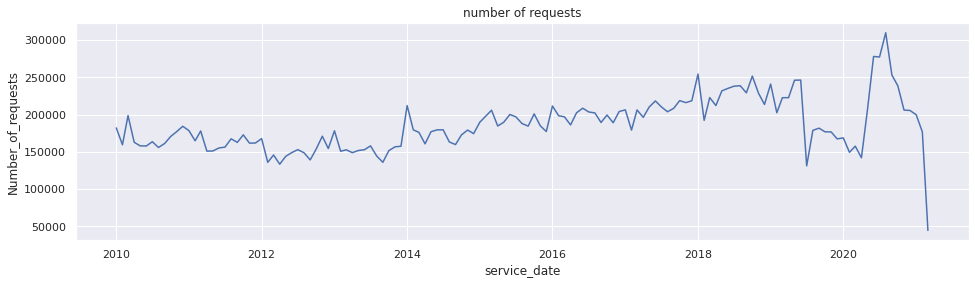

In [34]:
# Explore total rides over time

sns.lineplot(data=df, x=df.index, y=df[target]).set_title('number of requests')
#fig = plt.show()

### TODO 2: Review summary statistics

* How many records are in the dataset?
* What is the average # of requests per day?

In [36]:
df[target].describe().apply(lambda x: round(x))

count       135
mean     185791
std       35100
min       44685
25%      159626
50%      179514
75%      205920
max      309696
Name: Number_of_requests, dtype: int64

### TODO 3: Explore seasonality

* Is there much difference between months?
* Can you extract the trend and seasonal pattern from the data?

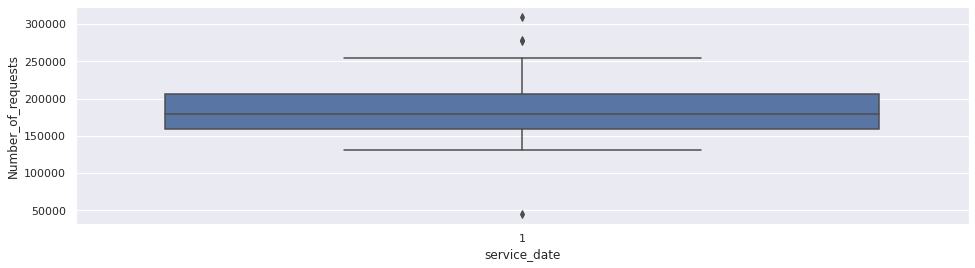

In [53]:
# Show the distribution of values for each day of the week in a boxplot:
# Min, 25th percentile, median, 75th percentile, max 

daysofweek = months = pd.to_datetime(df.index, errors='coerce').to_series().dt.day

fig = sns.boxplot(x=daysofweek, y=df[target])

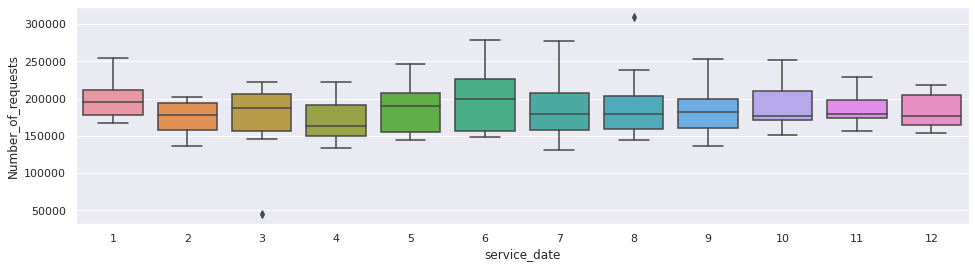

In [52]:
# Show the distribution of values for each month in a boxplot:

months = pd.to_datetime(df.index, errors='coerce').to_series().dt.month

fig = sns.boxplot(x=months, y=df[target])

### Auto-correlation

Next, we will create an auto-correlation plot, to show how correlated a time-series is with itself. Each point on the x-axis indicates the correlation at a given lag. The shaded area indicates the confidence interval.

Note that the correlation gradually decreases over time, but reflects weekly seasonality (e.g. `t-7` and `t-14` stand out).

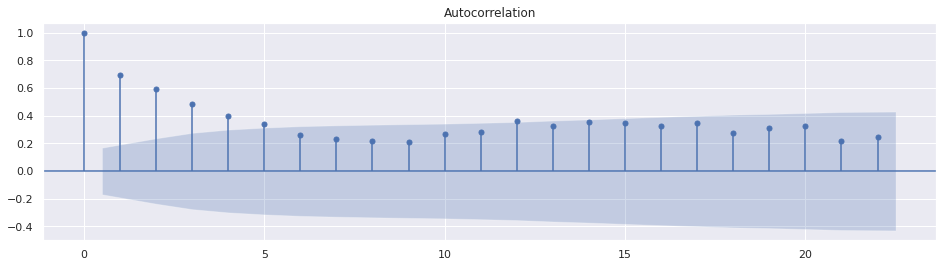

In [47]:
plot_acf(df[target])

fig = plt.show()

## Export data

This will generate a CSV file, which you will use in the next labs of this quest.
Inspect the CSV file to see what the data looks like.

In [54]:
df[[target]].to_csv("service_requests.csv", index=True, index_label=ts_col)

## Conclusion

You've successfully completed the exploration and visualization lab.
You've learned how to:
* Create a query that groups data into a time series
* Visualize data
* Decompose time series into trend and seasonal components